### 1. Four classifier: original, one with only sleep as feature, one only train on sleep class and one only train on awake class.

### 2. For 231 and 222_1, sleep classifier performs better than the awake classifier. 

### 3. For original classifier, the accuracy for sleep class is lower than that for awake class

### 4. Consider stratified both sleep class and label

In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble
import seaborn as sns
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv


import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hp/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pickle
p231_sleep_a = pickle.load(open(hp.prepath_pat + '231' +'_trained_sleep_awake.p', "rb" ))
p231_sleep_s = pickle.load(open(hp.prepath_pat + '231' +'_trained_sleep_sleep.p', "rb" ))
p231_sleep = pickle.load(open(hp.prepath_pat + '231' +'_trained_sleep.p', "rb" ))
p231 = pickle.load(open(hp.prepath_pat + '231' +'_trained.p', "rb" ))

p222_sleep_a = pickle.load(open(hp.prepath_pat + '222_1' +'_trained_sleep_awake.p', "rb" ))
p222_sleep_s = pickle.load(open(hp.prepath_pat + '222_1' +'_trained_sleep_sleep.p', "rb" ))
p222_sleep = pickle.load(open(hp.prepath_pat + '222_1' +'_trained_sleep.p', "rb" ))
p222 = pickle.load(open(hp.prepath_pat + '222_1' +'_trained.p', "rb" ))

In [3]:
#four classifier: original, one with only sleep as feature
pat = p231
X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
clf = pat.estimator[7]
pred = clf.predict(X_test[:, 1:29])
print('Accuracy for predicting sleep class is ', np.sum(X_test[pred == y_test,0] > 0)/np.sum(X_test[:,0] > 0)) #sleep
print('Accuracy for predicting awake class is ', np.sum(X_test[pred == y_test,0] < 0)/np.sum(X_test[:,0] < 0)) #awake
print('sleep total', np.sum(X_test[:,0] > 0))
print('awake total', np.sum(X_test[:,0] < 0))
pat = p222
X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
clf = pat.estimator[2]
pred = clf.predict(X_test[:, 1:29])
print('Accuracy for predicting sleep class is ', np.sum(X_test[pred == y_test,0] > 0)/np.sum(X_test[:,0] > 0)) #sleep
print('Accuracy for predicting awake class is ', np.sum(X_test[pred == y_test,0] < 0)/np.sum(X_test[:,0] < 0)) #awake


Accuracy for predicting sleep class is  0.825
Accuracy for predicting awake class is  0.8848920863309353
sleep total 40
awake total 139
Accuracy for predicting sleep class is  0.7291666666666666
Accuracy for predicting awake class is  0.7142857142857143


0
scores for original
1
scores for use sleep as feature
2
scores for classifier for awake time
3
scores for classifier for sleep time


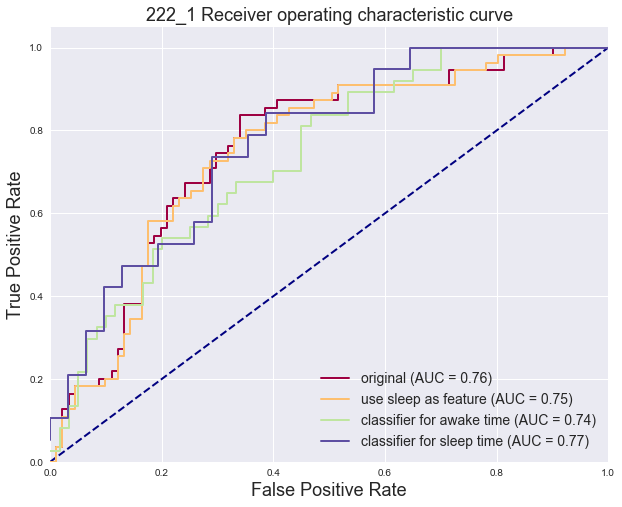

In [13]:
#
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

#pat_list = [p231,p231_sleep,p231_sleep_s,p231_sleep_a]
pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

cmap = plot_funcs.get_cmap(len(pat_list))
lw = 2
plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    print(i)
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 1)
        classifier_int = 1
        label = 'classifier for sleep time'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 0)
        classifier_int = 1
        label = 'classifier for awake time'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
        classifier_int = 2
        label = 'use sleep as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1)
        classifier_int = 2
        label = 'original'
    print('scores for ' + label)
#    JJ.scores_estimators(X_test, y_test, pat = pat)
#     if i != 1:
#         plot_funcs.feature_importance(pat,classifier_int)
    y_score, accuracy, y_pred, clf_name = JJ.load_score(classifier_int, X_test, y_test, pat)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)        
    
    plt.plot(fpr, tpr, color=cmap(i),
           lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend()
    plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
    plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
    plt.title(pat.id +' Receiver operating characteristic curve', fontsize=hp.label_fontsize)

plt.legend(prop={'size': 14})
plt.savefig(hp.prepath_sleep + pat.id + ' roc')
plt.show()

0
scores for 222_1 original


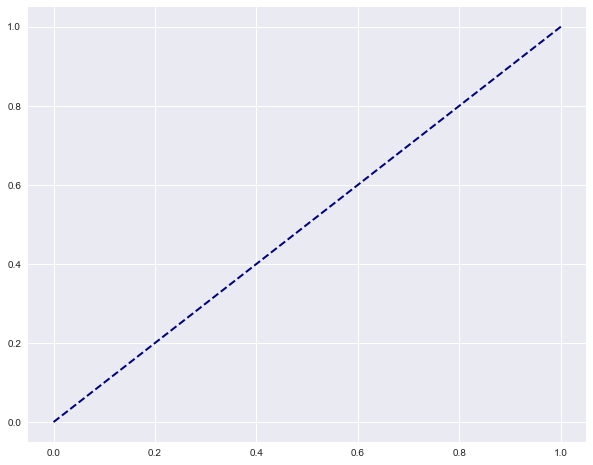

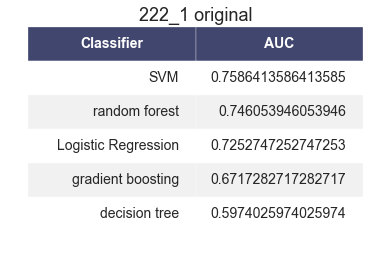

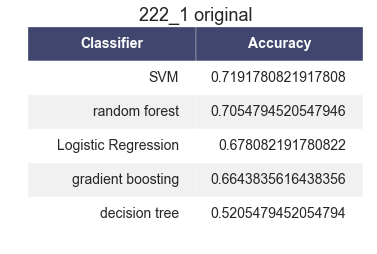

1
scores for 222_1 use sleep as feature


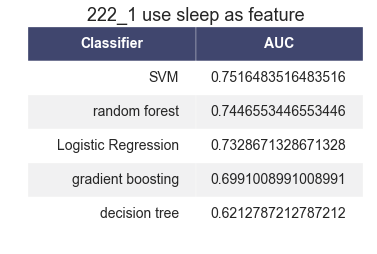

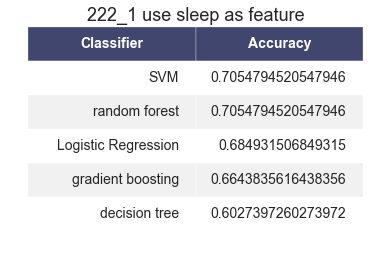

2
scores for 222_1 classifier for awake time


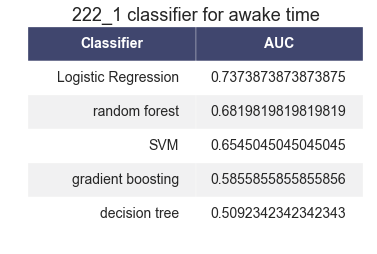

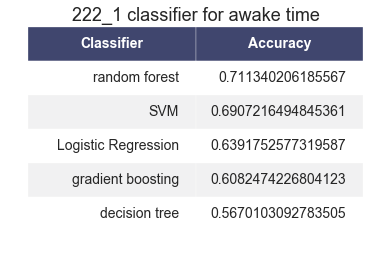

3
scores for 222_1 classifier for sleep time


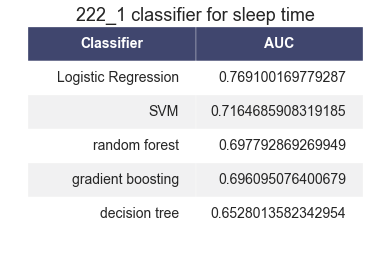

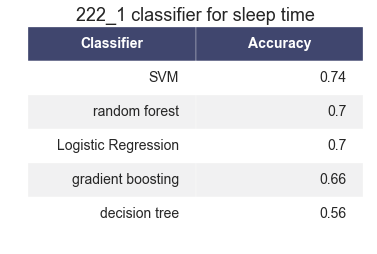

In [7]:
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p231,p231_sleep,p231_sleep_s,p231_sleep_a]
pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

cmap = plot_funcs.get_cmap(len(pat_list))
lw = 2
# plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    print(i)
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 1)
        classifier_int = 1
        label = pat.id + ' ' + 'classifier for sleep time'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 0)
        classifier_int = 1
        label = pat.id + ' ' + 'classifier for awake time'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
        classifier_int = 2
        label = pat.id + ' ' + 'use sleep as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1)
        classifier_int = 2
        label = pat.id + ' ' + 'original'
    print('scores for ' + label)
    JJ.scores_estimators(X_test, y_test, pat = pat, label = label)
#     if i != 1:
#         plot_funcs.feature_importance(pat,classifier_int)
#     y_score, accuracy, y_pred, clf_name = JJ.load_score(classifier_int, X_test, y_test, pat)
#     fpr, tpr, _ = roc_curve(y_test, y_score)
#     roc_auc = auc(fpr, tpr)        
    
#     plt.plot(fpr, tpr, color=cmap(i),
#            lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.legend()
#     plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
#     plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
#     plt.title('Receiver operating characteristic curve', fontsize=hp.label_fontsize)

# plt.legend(prop={'size': 14})
# plt.savefig(hp.prepath_cp + pat.id + '_sleep_' + 'roc')
# plt.show()

0
scores for 222_1 original


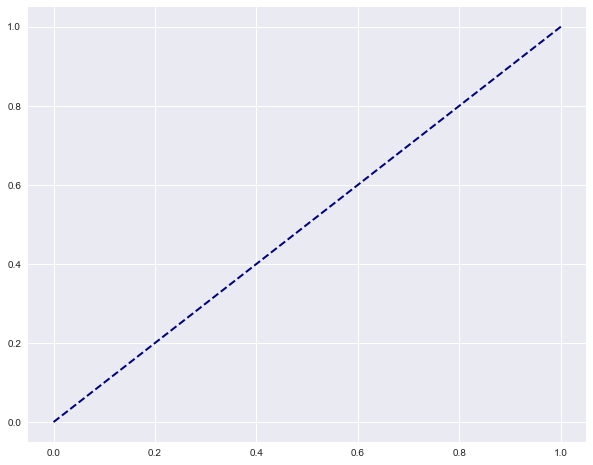

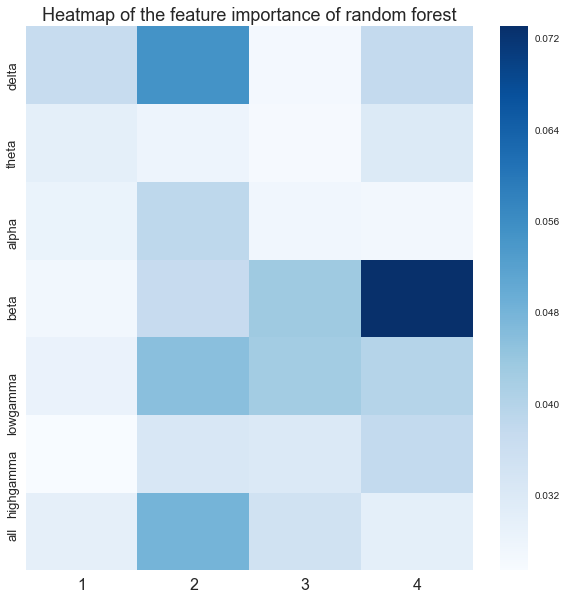

1
scores for 222_1 use sleep as feature
2
scores for 222_1 classifier for awake time


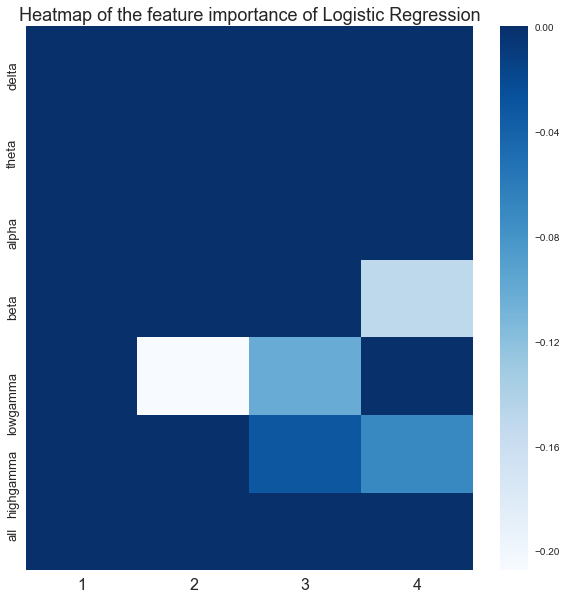

3
scores for 222_1 classifier for sleep time


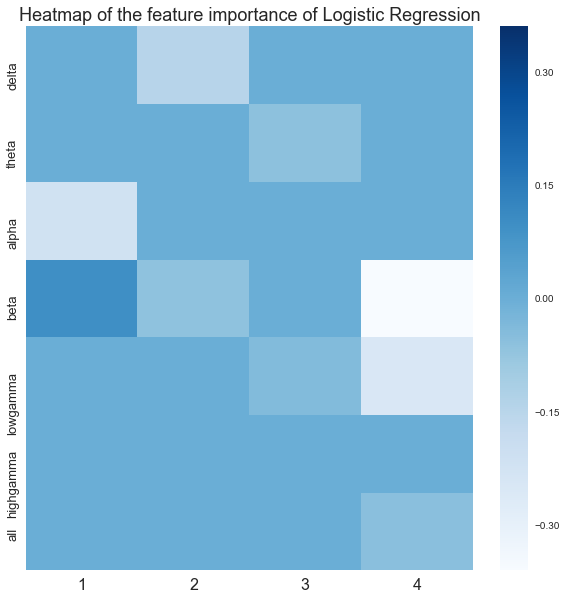

In [7]:
from sklearn.metrics import mean_squared_error, make_scorer, roc_curve, auc

pat_list = [p231,p231_sleep,p231_sleep_s,p231_sleep_a]
pat_list = [p222,p222_sleep,p222_sleep_s,p222_sleep_a]

cmap = plot_funcs.get_cmap(len(pat_list))
lw = 2
# plt.figure()
ax = plt.subplot(111)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
for i,pat in enumerate(pat_list):
    print(i)
    if i == 3:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 1)
        classifier_int = 1
        label = pat.id + ' ' + 'classifier for sleep time'
    elif i == 2:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1, sleep_class = 0)
        classifier_int = 1
        label = pat.id + ' ' + 'classifier for awake time'
    elif i == 1:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 0)
        classifier_int = 2
        label = pat.id + ' ' + 'use sleep as feature'
    elif i ==0:
        X_train, X_test, y_train, y_test = modules.get_ml_data(pat, if_remove_sleep = 1)
        classifier_int = 6
        label = pat.id + ' ' + 'original'
    print('scores for ' + label)
    #JJ.scores_estimators(X_test, y_test, pat = pat, label = label)
    if i != 1:
        plot_funcs.feature_importance(pat,classifier_int)
#     y_score, accuracy, y_pred, clf_name = JJ.load_score(classifier_int, X_test, y_test, pat)
#     fpr, tpr, _ = roc_curve(y_test, y_score)
#     roc_auc = auc(fpr, tpr)        
    
#     plt.plot(fpr, tpr, color=cmap(i),
#            lw=lw, label='%s (AUC = %0.2f)' % (label, roc_auc))
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.legend()
#     plt.xlabel('False Positive Rate', fontsize=hp.label_fontsize)
#     plt.ylabel('True Positive Rate', fontsize=hp.label_fontsize)
#     plt.title('Receiver operating characteristic curve', fontsize=hp.label_fontsize)

# plt.legend(prop={'size': 14})
# plt.savefig(hp.prepath_cp + pat.id + '_sleep_' + 'roc')
# plt.show()